In [1]:
from math import sqrt

# Preamble
import numpy as np
import healpy as hp
import libpol as lp

# Plotting 
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def planck_cmap_txt(cmapfile):
    planck_cmap = ListedColormap(np.loadtxt(cmapfile)/255.) 
    planck_cmap.set_bad("gray")
    planck_cmap.set_under("white")
    return planck_cmap

planck_256_cmap = planck_cmap_txt("./Planck_Parchment_RGB.txt")

# Finding non-polarized points in the CMB polarisation field

For a Gaussian simulation, start by choosing a power spectrum.

In [2]:
ps_r005 = hp.read_cl("./cl_TEB_r0.05000.fits")

Interacting with maps, subareas and NPPs is driven through the NPPAnalysis object, which can be created from either a power spectrum or fits file.

In [3]:
nppa = lp.NppAnalysis.from_power_spectrum(ps_r005, seed=17, data_nside=512, subarea_nside=4, fwhm_rad=np.radians(2), harmonics="full")

In [4]:
# Resolution for the gnomonic view based on SP_NSIDE
d2e = hp.max_pixrad(nppa.sp_nside, degrees=True)
resolution = lambda xs : (1.5*d2e*60)/xs

As an example, show the polarisation map we just created.

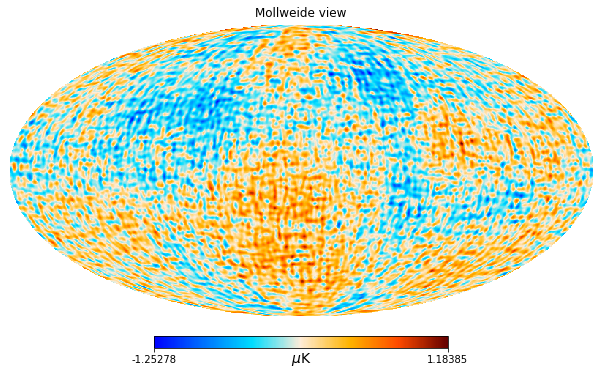

In [5]:
hp.mollview(nppa.q_map, nest=True, cmap=planck_256_cmap, unit=r"$\mu$K")

## Calibrate for $\varepsilon$ value

Theory provides an expected count for the number of NPPs in the whole sky, based on the radius of correlation.

In [6]:
target_spcount = 1/nppa.rc**2
target_spcount

4021.544997499617

Use the bisection method to find the root of the function
To find a matching value for $\varepsilon$, we use bisection to find the root of the function
\begin{gather}
    f(\varepsilon) = \text{spa.npps_all_subareas}(\varepsilon) - \frac{1}{r_c^2}.
\end{gather}

First we figure out upper and lower bounds for $\varepsilon$ by evaluating the number of non-polarized points at arbitrary samples.
The true number should be bracketed by the lower and upper guesses.

In [7]:
epsilon_values, npp_counts = nppa.bisect_epsilon(0.02, 0.05, max_iterations=15, cutoff=1)

Iteration: 8
Evaluating: 0.0451953125
Evaluated difference: 0.4550025003832161


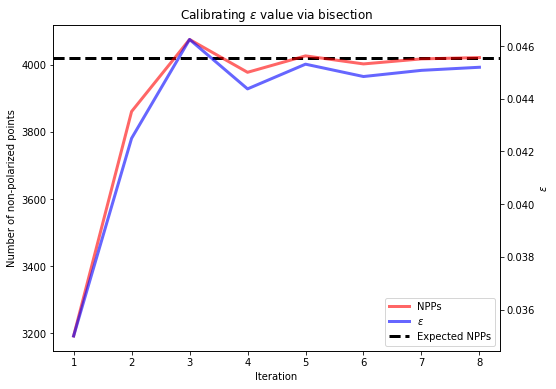

In [8]:
# Plot learning the correct epsilon value
iterations = range(1, len(epsilon_values)+1)

fig, ax = plt.subplots(figsize=(8,6))
ax.set_title(r"Calibrating $\varepsilon$ value via bisection")

# Twin axis for epsilon value
ax_ = ax.twinx()

# Horizontal line for expected count of non-polarized points
exp_line = ax.axhline(target_spcount, color="black", ls="--", lw=3, label="Expected NPPs")

epsiplot_kwargs = {
    "alpha": 0.6,
    "lw": 3
}

# Plot data
sp_line = ax.plot(iterations, npp_counts + target_spcount, color="red", label="NPPs", **epsiplot_kwargs)
epsilon_line = ax_.plot(iterations, epsilon_values, color="blue", label=r"$\varepsilon$", **epsiplot_kwargs)

# Axis labels
ax.set_xlabel("Iteration")
ax.set_ylabel("Number of non-polarized points")
ax_.set_ylabel(r"$\varepsilon$")

# Add legend
lines = sp_line + epsilon_line + [exp_line]
labels = [l.get_label() for l in lines]
ax.legend(lines, labels)

plt.show()

In [9]:
calibrated_epsilon = epsilon_values[-1]
calibrated_epsilon

0.0451953125

This is all the code needed to query the NPPs in a given subarea. Just the subarea pixel, and a value for $\varepsilon$.

In [10]:
mother = 3
focuses, knots, saddles = nppa.npps_in_subarea(mother, calibrated_epsilon)

sample_focuses_lonlats = np.array(hp.pix2ang(nppa.data_nside, focuses, nest=True, lonlat=True))
sample_knots_lonlats = np.array(hp.pix2ang(nppa.data_nside, knots, nest=True, lonlat=True))
sample_saddles_lonlats = np.array(hp.pix2ang(nppa.data_nside, saddles, nest=True, lonlat=True))

We'll also query the locations of all pixels below epsilon, for comparison with where the actual NPPs ended up.

In [11]:
daughters = lp.pixel.daughter_pixels(mother, nppa.data_nside, nppa.sp_nside)

sub_epsilon_pixels = lp.pixel.sub_epsilon_intersect(calibrated_epsilon, daughters, nppa.pi_map)
sub_epsilon_lonlats = np.array(hp.pix2ang(nppa.data_nside, sub_epsilon_pixels, nest=True, lonlat=True))

## Cold pixels and NPPs

In [12]:
# Center on chosen subarea
lon, lat = hp.pix2ang(nppa.sp_nside, mother, nest=True, lonlat=True)

bg = np.full((12*nppa.data_nside**2,), hp.UNSEEN)
fig, ax = plt.subplots(ncols=2, figsize=(20, 30))
bg[daughters] = nppa.pi_map[daughters]

gnom_kwargs = {
    "map": bg,
    "rot": (lon, lat),
    "nest": True,
    "reso": resolution(1500),
    "xsize": 1500,
    "hold": True,
    "cbar": False,
    "notext": True,
    "cmap": planck_256_cmap,
}

scatter_kwargs = {
    "lonlat": True,
    "color": "red",
    #"hold": True
}


plt.axes(ax[0])
hp.gnomview(title="a.", **gnom_kwargs)

hp.projscatter(sub_epsilon_lonlats, marker="o", **scatter_kwargs)

plt.axes(ax[1])
hp.gnomview(title="b.", **gnom_kwargs)

hp.projscatter(sample_focuses_lonlats, marker="o", s=200, **scatter_kwargs)
hp.projscatter(sample_knots_lonlats, marker="^", s=200, **scatter_kwargs)
hp.projscatter(sample_saddles_lonlats, marker="*", s=200, **scatter_kwargs)

plt.show()

Both figures a. and b. have the polarization intensity in the subareas pixel 3 as their background.

Figure b. overlays just the NPPs on on this background. Foci are the 3 circles, the 2 triangles are the knots and the 4 stars are saddles.

Figure a. highlights all pixels colder than epsilon. We can see local minima that are not colder than epsilon together with sufficiently cold minima where the local minima were not classified as NPPs in figure b., due to a crossing point for both the Q and U fields not being present.

## Calculate ratios in all subareas
Theory also predicts specific values for the ratios of singular point counts. Next we count the singular points in all subareas and evaluate the ratios.

Since we are working with such a small, smoothed map, we'll encounter a very coarse-grained distribution.

In [13]:
foci_counts, knots_counts, saddle_counts = nppa.npps_all_subareas(calibrated_epsilon)

[####################] 100.0%


In [14]:
fk_ixs = knots_counts > 0
fs_ixs = saddle_counts > 0

fk_ratios = foci_counts[fk_ixs] / knots_counts[fk_ixs]
fs_ratios = foci_counts[fs_ixs] / saddle_counts[fs_ixs]

In [15]:
fig, ax = plt.subplots(ncols=2)

hist_kwargs = {
    "bins": 5,
    "density": True,
    "alpha": .5
}

ax[0].hist(fk_ratios, **hist_kwargs)
ax[1].hist(fs_ratios, **hist_kwargs)

# Lines for theoretical expectation
ax[0].axvline(sqrt(2)+1, ls="--", color="black")
ax[1].axvline(sqrt(2)/2, ls="--", color="black")

ax[0].set_title("f/k ratios")
ax[1].set_title("f/s ratios")
plt.show()